In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import random

In [110]:
#Choose the pattern you want to use for your data, you will visualize the data a bit later
pattern = 'spiral'
#pattern = 'double_circle'

In [111]:
nombre_element = 1500

if pattern == 'spiral':
    t = np.linspace(0, 6*np.pi, nombre_element)
    x0 = np.zeros((nombre_element, 2)) 
    x1 = np.zeros((nombre_element, 2)) 
    color = np.zeros((nombre_element,2))

    for i in range(nombre_element):
        r = np.abs(t[i])
        x0[i,0] = r*np.cos(t[i]) 
        x0[i,1] = r*np.sin(t[i]) + 3*np.random.rand()
        color[i,0] = 0
        x1[i,0] =  -r*np.cos(t[i])
        x1[i,1] =  - r*np.sin(t[i]) + 2*np.random.rand()
        color[i,1] = 1
        
if pattern == 'double_circle':
    t = np.linspace(0, 2*np.pi, nombre_element)
    x0 = np.zeros((nombre_element, 2)) 
    x1 = np.zeros((nombre_element, 2)) 
    color = np.zeros((nombre_element,2))

    for i in range(nombre_element):
        x0[i,0] = np.cos(t[i]) + np.random.normal(0,0.2)
        x0[i,1] = np.sin(t[i]) + np.random.normal(0,0.2)
        color[i,0] = 0
        x1[i,0] =  2*np.cos(t[i]) + np.random.normal(0,0.5)
        x1[i,1] =  2*np.sin(t[i]) + np.random.normal(0,0.5)
        color[i,1] = 1

In [112]:
df = pd.DataFrame()
df['x'] = np.concatenate((x0[:,0],x1[:,0])).tolist()
df['y'] = np.concatenate((x0[:,1],x1[:,1])).tolist()
df['color'] = np.concatenate((color[:,0],color[:,1])).tolist()

print(df.head())
print(df.shape)

          x         y  color
0  0.000000  2.021684    0.0
1  0.012574  1.209318    0.0
2  0.025142  2.173470    0.0
3  0.037697  0.849588    0.0
4  0.050235  2.274192    0.0
(3000, 3)


In [113]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y",color="color", marginal_y="histogram", marginal_x="histogram")
fig.show()

In [114]:
#randomizing the data and we keep 20% of it to test the model
val_size = int(df.shape[0] * 0.2)

df = df.sample(frac=1).reset_index(drop=True)

X_train = df[['x','y']].values[:-val_size]
Y_train = df['color'].values[:-val_size]
Y_train = Y_train.reshape(-1,1)

X_val = df[['x','y']].values[-val_size:]
Y_val = df['color'].values[-val_size:]
Y_val = Y_val.reshape(-1,1)

In [115]:
def random_batch(X_train, Y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    Y_batch = Y_train[rnd_indices]
    return X_batch, Y_batch

In [116]:
n_inputs = 2
nb_hidden = 32
nb_hidden2 = 16

X_ = tf.placeholder(tf.float32, shape=(None, n_inputs))

Y_ = tf.placeholder(tf.float32, shape=(None, 1))

_w = tf.Variable(tf.random_uniform([n_inputs, nb_hidden], -0.1, 0.1))
_w2 = tf.Variable(tf.random_uniform([nb_hidden, nb_hidden2], -0.1, 0.1))
_w3 = tf.Variable(tf.random_uniform([nb_hidden2, 1], -0.1, 0.1))


_b = tf.Variable(0.1)
_b2 = tf.Variable(0.1)
_b3 = tf.Variable(0.1)

_logits = tf.nn.relu(tf.nn.relu(X_@_w +_b)@_w2 + _b2)@_w3 + _b3
_Y_proba = tf.sigmoid(_logits)

In [117]:
epsilon = 1e-7
_loss = -tf.reduce_mean(Y_ * tf.log(_Y_proba + epsilon) + (1 - Y_) * tf.log(1 - _Y_proba + epsilon))

In [120]:
learning_rate = 0.001
_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
_training_op = _optimizer.minimize(_loss)

In [121]:
m = nombre_element
batch_size = 120
n_batches = m // batch_size

losses_val=[]
ite_val=[]
losses_train=[]
ite_train=[]

sess=tf.Session()
sess.run(tf.global_variables_initializer())

ite=0

for epoch in range(1000):
    for batch_index in range(n_batches):
        ite+=1
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size)
        loss,_=sess.run([_loss,_training_op], feed_dict={X_: X_batch, Y_: Y_batch})
        losses_train.append(loss)
        ite_train.append(ite)
        
    
    loss_val = sess.run(_loss, feed_dict={X_: X_val, Y_: Y_val})
    ite_val.append(ite)
    losses_val.append(loss_val)
    if epoch%100 ==0 : print("Epoch:", epoch, "\t Loss val:", loss_val)

Epoch: 0 	 Loss val: 0.6912764
Epoch: 100 	 Loss val: 0.66011864
Epoch: 200 	 Loss val: 0.6455189
Epoch: 300 	 Loss val: 0.6188134
Epoch: 400 	 Loss val: 0.5487649
Epoch: 500 	 Loss val: 0.5095121
Epoch: 600 	 Loss val: 0.4709662
Epoch: 700 	 Loss val: 0.4384855
Epoch: 800 	 Loss val: 0.40201265
Epoch: 900 	 Loss val: 0.3616921


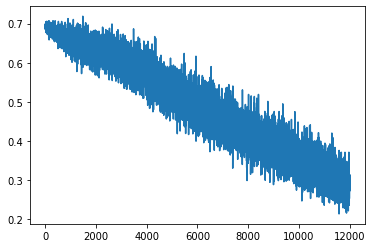

In [122]:
plt.plot(losses_train)

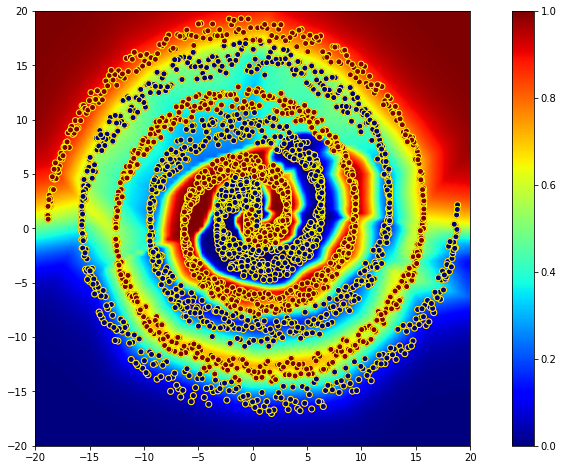

In [123]:
#change the linspace according to the plot above

xx0=np.linspace(-20,20,100)
xx1=np.linspace(-20,20,100)
XX0,XX1=np.meshgrid(xx0,xx1)
length=len(XX0.reshape(-1))

XX01=np.stack([XX0.reshape(-1),XX1.reshape(-1)],axis=1)

hat_Y_proba = sess.run(_Y_proba,feed_dict={X_: XX01})
hat_Y_proba=hat_Y_proba.reshape(XX0.shape)

fig,ax=plt.subplots(figsize=(15,8))
mappable=ax.imshow(hat_Y_proba,origin="lower", interpolation='bilinear' ,cmap="jet",extent=[-20,20,-20,20])
mappable=ax.scatter(df['x'],df['y'],c=df['color'],cmap="jet",marker="o",edgecolor="r");
mappable=ax.scatter(df['x'].values,df['y'].values,c=df['color'].values,cmap="jet",marker="o",edgecolor="yellow");
fig.colorbar(mappable)